In [1]:
%load_ext autoreload
%autoreload 2    

In [2]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time
import pandas as pd 
import matplotlib.pyplot as plt
from IPython.display import clear_output
import cv2
import torchmetrics

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
import numpy as np
# ! pip install opencv-python==4.5.5.64
import cv2 

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
batch_size = 8

# Augmentation

In [6]:
def visualize_img_and_label():

    
    plt.figure(figsize=(10, 4))
    for i in range(5):
        im, lb = trainset.__getitem__(i)
        plt.subplot(2, 5, i+1)
        plt.imshow(im.permute(1,2,0))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(2, 5, 6+i)
        plt.imshow(lb) # lab.permute(1,2,0)
        plt.xticks([])
        plt.yticks([])
        plt.subplots_adjust(hspace=0, wspace=0)
    plt.show()

In [7]:
from data_loader import PH2, DRIVE

In [8]:
size = 128

train_transform = A.Compose(
    [
        A.Resize(size, size),
        A.Rotate(limit=90, p=1, border_mode=cv2.BORDER_CONSTANT),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.GaussNoise(p=0.5),
        A.Flip(p=0.5),
        A.Normalize(),
        ToTensorV2(),
        
    ]
)

test_transform = A.Compose([A.Resize(size, size), 
                            A.Normalize(),
                            ToTensorV2()])




In [9]:
trainset = PH2('train', transform=train_transform)
valset = PH2('val', transform=test_transform)
testset = PH2('test', transform=test_transform)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8,)# persistent_workers=True, pin_memory=True)
val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=8,)# persistent_workers=True, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


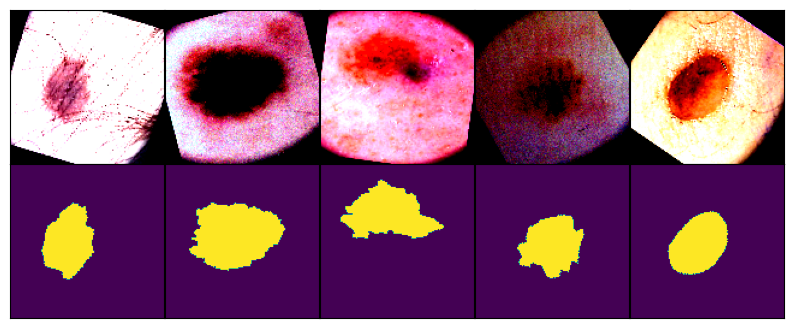

In [10]:
visualize_img_and_label()

# Model

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.first_layer = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
        )

                
        self.middle_layer = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64)
        )

        self.concat_layer = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(64)
        )
        
        
        self.end_layer = nn.Sequential(
            nn.Conv2d(128, 1, 3, padding=1),
            nn.ReLU()
        )
        

    def forward(self, x):
        # encoder
        x0 = self.first_layer(x)
        x = self.middle_layer(x0)
        x = self.middle_layer(x)
        x = self.middle_layer(x)

        x = torch.concat([x, x0], 1)
        x1 = self.concat_layer(x)
        x = self.middle_layer(x1)
        x = self.middle_layer(x)
        
        x = torch.concat([x, x1], 1)
        x2 = self.concat_layer(x)
        x = self.middle_layer(x2)
        x = self.middle_layer(x)

        
        x = torch.concat([x, x1], 1)
        x = self.end_layer(x)
        return F.sigmoid(x)

In [12]:
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 1, 3, padding=1)
        
    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(e0))
        e2 = F.relu(self.enc_conv2(e1))

        # no activation
        e3 = self.enc_conv3(e2)
        
        return e3

# Train

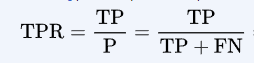

In [17]:
import torch
from torchmetrics import Metric

class Sensitivity(Metric):
    def __init__(self, num_classes=2, threshold=0.5, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.num_classes = num_classes
        self.threshold = threshold
        self.add_state("true_positives", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("false_negatives", default=torch.zeros(num_classes), dist_reduce_fx="sum")

    def update(self, preds, target):
        preds = (preds >= self.threshold).int()
        target = target.int()

        true_positives = torch.sum(preds * target, dim=0)
        false_negatives = torch.sum(target * (1 - preds), dim=0)

        self.true_positives += true_positives
        self.false_negatives += false_negatives

    def compute(self):
        sensitivity = self.true_positives / (self.true_positives + self.false_negatives + 1e-8)
        return sensitivity

    def reset(self):
        self.true_positives.zero_()
        self.false_negatives.zero_()


In [54]:
def train(model, opt, loss_fn, epochs, train_loader, val_loader, test_loader):

    train_loss = []
    val_loss = []


    metric_dict = {
                'train_dice': torchmetrics.Dice().to(device),
                'train_iou': torchmetrics.JaccardIndex('binary').to(device),
                'train_acc': torchmetrics.Accuracy('binary').to(device),
                'train_sens': Sensitivity().to(device),
                'train_spec': torchmetrics.Specificity('binary').to(device),
                
                'val_dice': torchmetrics.Dice().to(device),
                'val_iou': torchmetrics.JaccardIndex('binary').to(device),
                'val_acc': torchmetrics.Accuracy('binary').to(device),
                'val_sens': Sensitivity().to(device),
                'val_spec': torchmetrics.Specificity('binary').to(device),

                                
                'test_dice': torchmetrics.Dice().to(device),
                'test_iou': torchmetrics.JaccardIndex('binary').to(device),
                'test_acc': torchmetrics.Accuracy('binary').to(device),
                'test_sens': Sensitivity().to(device),
                'test_spec': torchmetrics.Specificity('binary').to(device),
               }

    out_dict = {
                
                'train_loss':[],
                'train_dice': [],
                'train_iou': [],
                'train_acc': [],
                'train_sens': [],
                'train_spec': [],

                'val_loss':[],
                'val_dice': [],
                'val_iou':[],
                'val_acc': [],
                'val_sens': [],
                'val_spec': [],

                                
                'test_dice': [],
                'test_iou': [],
                'test_acc': [],
                'test_sens': [],
                'test_spec': [],
    }

    
    for epoch in range(epochs):
        tic = time()
        
        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss = loss_fn(Y_pred, Y_batch)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)

            metric_dict['train_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['train_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

            
        toc = time()

        model.eval()  # testing mode
        for X_batch, Y_batch in val_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            
            Y_pred = model(X_batch)
            Y_batch = Y_batch.unsqueeze(1)
            loss_test = loss_fn(Y_pred, Y_batch)  # forward-pass
            avg_loss_val += loss / len(val_loader)

            metric_dict['val_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            metric_dict['val_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
            
        
        train_loss.append(avg_loss.detach().cpu())
        val_loss.append(avg_loss_val.detach().cpu())

        #plt.plot(train_loss, np.arange(len(train_loss)))
        #plt.plot(test_loss, np.arange(len(test_loss)))
                 
        for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
            out_dict['train_' + metric].append(metric_dict['train_' + metric].compute())
            out_dict['val_' + metric].append(metric_dict['val_' + metric].compute())

        
        print(f"Loss train: {avg_loss:.3f}\t Val Acc: {metric_dict['val_acc'].compute():.3f}\t, Val Dice: {metric_dict['val_dice'].compute()}")

    model.eval()  # testing mode
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        
        Y_pred = model(X_batch)
        Y_batch = Y_batch.unsqueeze(1)

        metric_dict['test_dice'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_acc'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_iou'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['val_sens'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))
        metric_dict['test_spec'](F.sigmoid(Y_pred.flatten()), Y_batch.flatten().to(int))

    for metric in ['dice', 'acc', 'iou', 'sens', 'spec']:
        out_dict['test_' + metric].append(metric_dict['test_' + metric].compute())

    out_dict['train_loss'] = train_loss
    out_dict['test_loss'] = test_loss
    
    
    return out_dict, metric_dict


    
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

In [55]:
model = EncDec().to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [56]:
out_dict, metric_dict = train(model, optim.Adam(model.parameters(), 0.0001), loss_fn, 50, train_loader, val_loader, test_loader)

Loss train: 0.629	 Val Acc: 0.611	, Val Dice: 0.0
Loss train: 0.502	 Val Acc: 0.655	, Val Dice: 0.20800848305225372
Loss train: 0.444	 Val Acc: 0.702	, Val Dice: 0.4425497055053711
Loss train: 0.429	 Val Acc: 0.725	, Val Dice: 0.5420501828193665
Loss train: 0.408	 Val Acc: 0.740	, Val Dice: 0.5902919769287109
Loss train: 0.398	 Val Acc: 0.750	, Val Dice: 0.6236425042152405
Loss train: 0.377	 Val Acc: 0.757	, Val Dice: 0.6452063918113708
Loss train: 0.386	 Val Acc: 0.763	, Val Dice: 0.6610180735588074
Loss train: 0.360	 Val Acc: 0.768	, Val Dice: 0.6733332276344299
Loss train: 0.392	 Val Acc: 0.772	, Val Dice: 0.6829968690872192
Loss train: 0.359	 Val Acc: 0.775	, Val Dice: 0.6903243660926819
Loss train: 0.387	 Val Acc: 0.778	, Val Dice: 0.6963825225830078
Loss train: 0.360	 Val Acc: 0.781	, Val Dice: 0.7016416788101196
Loss train: 0.383	 Val Acc: 0.784	, Val Dice: 0.7061161994934082
Loss train: 0.385	 Val Acc: 0.786	, Val Dice: 0.7099546194076538
Loss train: 0.390	 Val Acc: 0.788	, Val

/zhome/8d/e/198218/dlincv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric Dice was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/zhome/8d/e/198218/dlincv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric BinaryAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/zhome/8d/e/198218/dlincv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute`` method of metric BinaryJaccardIndex was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/zhome/8d/e/198218/dlincv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: The ``compute

NameError: name 'test_loss' is not defined